In [89]:
import re
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

import ProcessLogs as pl

In [90]:
class ProcessLogsTest:
    def __init__(self,altura:int,velocidad:int):
        self.carpeta = Path("data_bruta")
        self.color_cycle=cycle( plt.rcParams['axes.prop_cycle'].by_key()['color'])
        self.altura = altura
        self.velocidad = velocidad
        self.load_files()
        self.load_data()

    def load_files(self):
        patron = re.compile(r"log_alt_(\d+)_v_(\d+)_.*\.txt$")
        self.archivos_seleccionados = [
            archivo for archivo in self.carpeta.iterdir()
            if archivo.is_file() and (m := patron.match(archivo.name)) and m.group(1) == str(self.altura) and m.group(2) == str(self.velocidad)
        ]
    
    def load_data(self):

        self.imus = []
        self.attitudes = []
        self.maneuvers = []
        self.positions = []


        for archivo in self.archivos_seleccionados:
            imu_i = pl.log_imus(archivo)
            attitude_i=pl.log_attitude(archivo)
            maneuver_i=pl.log_maneuver(archivo)
            position_i=pl.log_position(archivo)
            
            self.imus.append(imu_i)
            self.attitudes.append(attitude_i)
            self.maneuvers.append(maneuver_i)
            self.positions.append(position_i)   

    def plot_positions(self):
        fig,ax = plt.subplots(2,1,figsize=(10,5))
        
        for index,flight in enumerate(self.positions):
            color=next(self.color_cycle)

            t0=flight['time_boot_ms'][0]
            time=[(time -t0)/1000 for time in flight['time_boot_ms']]
            altura=[h/1000 for h in flight['relative_alt']]
            gspeed=[np.sqrt(vx**2 + vy**2) /100 for vx,vy in zip(flight['vx'],flight['vy'])]

            idx_h_max = np.argmax(altura)
            idx_v_max = np.argmax(gspeed)

            time_h_crit = time[idx_h_max]
            time_v_crit = time[idx_v_max]

            ax[0].plot(time,altura,color=color,marker='+',label=f'# {index+1}')
            ax[0].axvline(x=time_h_crit,color=color, linestyle='--', alpha=0.3, linewidth=2)

            ax[1].plot(time,gspeed,color=color,marker='+',label=f'# {index+1}')
            ax[1].axvline(x=time_v_crit,color=color, linestyle='--', alpha=0.3, linewidth=2)



        ax[0].set_ylabel('Altura [m]')
        ax[1].set_ylabel('G.Speed [m/s]')
        
        
        ax[1].legend(loc='upper right',ncols=4)
        ax[1].set_xlabel('Tiempo [s]')
        plt.suptitle(f'Trigger: h = {self.altura} m y G.S = {self.velocidad} m/s')

    def plot_imus(self):
        fig,ax = plt.subplots(2,3,figsize=(10,5),sharey='row',sharex='col')

        for index,flight in enumerate(self.imus):
            color=next(self.color_cycle)

            for n,sensor in enumerate(flight):

                name_time='time_usec' if 'time_usec' in sensor else 'time_boot_ms'

                t0=sensor[name_time][0]
                
                if name_time == 'time_usec':
                    time=[(time_i -t0)*1e-6 for time_i in sensor[name_time]]
                else:
                    time=[(time_i -t0)*1e-3 for time_i in sensor[name_time]]

                long=[np.sqrt(xa**2+ya**2)*9.81e-3 for xa,ya in zip(sensor['xacc'],sensor['yacc'])]
                vert=[vert_i*9.81e-3 for vert_i in sensor['zacc']]

                ax[0,n].plot(time,long,color=color,marker='+',label=f'# {index+1}')
                ax[1,n].plot(time,vert,color=color,marker='+',label=f'# {index+1}')

        ax[0,0].set_ylabel('Aceleración Long [m/s²]')
        ax[1,0].set_ylabel('Aceleración Vert [m/s²]')

        ax[0,0].set_title('Raw IMU')
        ax[0,1].set_title('Scaled IMU 2')
        ax[0,2].set_title('Scaled IMU 3')
        plt.suptitle(f'Trigger: h = {self.altura} m y G.S = {self.velocidad} m/s')

    # def plot_box_imus(self):
    #     fig,ax = plt.subplots(2,3,figsize=(10,5),sharey='row',sharex='col')
        

    #     data = [[[] for _ in range(3)] for _ in range(2)]

    #     # 2) Recorre cada vuelo y cada sensor
    #     for flight in self.imus:
    #         for n, sensor in enumerate(flight):
    #             # Normaliza tiempo (si lo necesitas; aquí no lo usamos en el array)
    #             name_time = 'time_usec' if 'time_usec' in sensor else 'time_boot_ms'
    #             t0 = sensor[name_time][0]

    #             if name_time == 'time_usec':
    #                 time = [(ti - t0) for ti in sensor[name_time]]
    #             else:
    #                 time = [(ti - t0) / 1000 for ti in sensor[name_time]]
                
    #             # Calcula aceleraciones
    #             long = [np.sqrt(xa**2 + ya**2) * 9.81e-3 for xa, ya in zip(sensor['xacc'], sensor['yacc'])]
    #             vert = [zi * 9.81e-3 for zi in sensor['zacc']]
                
    #             # 3) Añade cada lista de aceleraciones al sitio correspondiente
    #             data[0][n].append(long)   # fila 0, columna n
    #             data[1][n].append(vert)   # fila 1, columna n
        
    #     for i in range(2):
    #         for j in range(3):
    #             ax[i,j].boxplot(data[i][j])
        
    #     # ax[0,0].set_ylabel('Aceleración Long [m/s²]')
    #     ax[1,0].set_ylabel('Aceleración Vert [m/s²]')

    #     ax[0,0].set_title('Raw IMU')
    #     ax[0,1].set_title('Scaled IMU 2')
    #     ax[0,2].set_title('Scaled IMU 3')
    #     plt.suptitle(f'Trigger: h = {self.altura} m y G.S = {self.velocidad} m/s')
    def plot_box_imus(self):
        fig, ax = plt.subplots(2, 3, figsize=(12, 6),
                            sharey='row', sharex='col')

        # Recolectar datos
        n_flights = len(self.imus)
        data = [[[] for _ in range(3)] for _ in range(2)]
        for flight in self.imus:
            for n, sensor in enumerate(flight):
                long = [np.sqrt(xa**2 + ya**2) * 9.81e-3
                        for xa, ya in zip(sensor['xacc'], sensor['yacc'])]
                vert = [zi * 9.81e-3 for zi in sensor['zacc']]
                data[0][n].append(long)
                data[1][n].append(vert)

        # Ciclo de color por vuelo
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[i % len(colors)] for i in range(n_flights)]

        for x in range(2):
            for y in range(3):
                bplot = ax[x, y].boxplot(
                    data[x][y],
                    patch_artist=True,
                    # notch=True,
                    tick_labels=[f'# {i+1}' for i in range(n_flights)]
                )
                # Colorear cada caja según el vuelo
                for patch, color in zip(bplot['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.6)
                    patch.set_edgecolor('black')
                # Opcional: colorear también los elementos asociados
                for element in ['whiskers', 'caps', 'medians', 'fliers']:
                    for i, item in enumerate(bplot[element]):
                        item.set_color('black')

                ax[x, y].tick_params(axis='x', rotation=45)

        ax[0,0].set_ylabel('Aceleración Long [m/s²]')
        ax[1,0].set_ylabel('Aceleración Vert [m/s²]')

        ax[0,0].set_title('Raw IMU')
        ax[0,1].set_title('Scaled IMU 2')
        ax[0,2].set_title('Scaled IMU 3')
        plt.suptitle(f'Trigger: h = {self.altura} m y G.S = {self.velocidad} m/s')

    def plot_attitudes(self):
        fig,ax = plt.subplots(2,3,figsize=(10,5),sharex=True)
        for index,flight in enumerate(self.attitudes):
            color=next(self.color_cycle)

            t0=flight['time_boot_ms'][0]
            time=[(time -t0)/1000 for time in flight['time_boot_ms']]

            ax[0,0].plot(time,flight['pitch'],color=color,marker='+',label=f'# {index+1}')
            ax[0,1].plot(time,flight['roll'],color=color,marker='+',label=f'# {index+1}')
            ax[0,2].plot(time,flight['yaw'],color=color,marker='+',label=f'# {index+1}')
            
            ax[1,0].plot(time,flight['pitchspeed'],color=color,marker='+',label=f'# {index+1}')
            ax[1,1].plot(time,flight['rollspeed'],color=color,marker='+',label=f'# {index+1}')
            ax[1,2].plot(time,flight['yawspeed'],color=color,marker='+',label=f'# {index+1}')
            
        ax[0,0].set_title('Pitch')
        ax[0,1].set_title('Roll')
        ax[0,2].set_title('Yaw')

        ax[0,0].set_ylabel('[rad]')
        ax[1,0].set_ylabel('[rad/s]')


        plt.suptitle(f'Trigger: h = {self.altura} m y G.S = {self.velocidad} m/s')
    
    def plot_maneuvers(self):
        fig,ax = plt.subplots(2,2,figsize=(10,5),sharex=True)
        for index,flight in enumerate(self.maneuvers):
            color=next(self.color_cycle)


            ax[0,0].plot(flight['alt'],color=color,marker='+',label=f'# {index+1}')
            ax[1,0].plot(flight['groundspeed'],color=color,marker='+',label=f'# {index+1}')

            ax[0,1].plot(flight['heading'],color=color,marker='+',label=f'# {index+1}')
            ax[1,1].plot(flight['climb'],color=color,marker='+',label=f'# {index+1}')

        ax[0,0].set_title('Altura')
        ax[1,0].set_title('Ground Speed')
        ax[0,1].set_title('Heading')    
        ax[1,1].set_title('Climb')
        ax[0,0].set_ylabel('[m]')
        ax[1,0].set_ylabel('[m/s]')
        
        ax[0,1].set_ylabel('[º]')
        ax[0,1].yaxis.set_label_position("right")
        ax[0,1].yaxis.tick_right()

        ax[1,1].set_ylabel('[m/s]')
        ax[1,1].yaxis.set_label_position("right")
        ax[1,1].yaxis.tick_right()  

        ax[0,0].legend(loc='center',ncols=4)

        plt.suptitle(f'Trigger: h = {self.altura} m y G.S = {self.velocidad} m/s')
           

In [91]:
alp=ProcessLogsTest(4, 2)

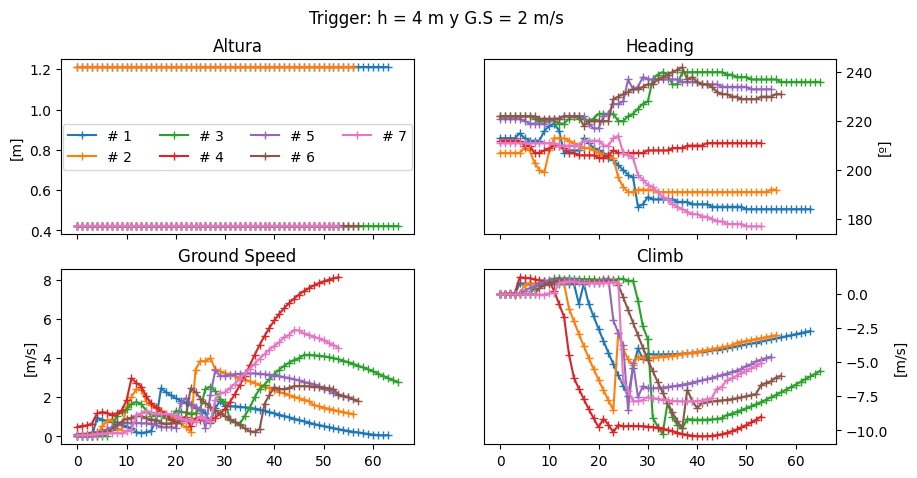

In [92]:
alp.plot_maneuvers()
            